In [1]:
import musclebeachtools_hlab as mbt
import neuraltoolkit as ntk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import numpy.linalg as la
import numpy.ma as ma
import sys
from datetime import date
import time
import glob, os
import pickle
import pandas as pd
import scipy
import scipy.cluster.hierarchy as spc
from statsmodels.sandbox.tsa.movstat import movmean
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as clr

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

basedir = '/hlabhome/sbrunwa/git/appps1'
pth = basedir + '/notebooks/figure_1/'

from matplotlib.colors import LinearSegmentedColormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

In [2]:
#                        Colors

with open(f'{basedir}/colormaps/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)
    
with open(f'{basedir}/colormaps/reg_colors.json') as json_file:
    reg_clrs = json.load(json_file)

with open(f'{basedir}/colormaps/sleep_colors.json') as json_file:
    sleep_clrs = json.load(json_file)
    
ld_clrs = {
    'light': '#f9ffcf',
    'dark': '#5C5C5C'
}

sleep_nums = {
    1: 'active',
    2: 'NREM',
    3: 'REM',
    }

dump = 0

In [3]:
def zscore_all(data):
    '''
    Perform z score on input.

    (X - mean(X)) / std(X)
    '''
    return (data - np.mean(data))/np.std(data)

def return_sleep_scores(f):
    sleep_states = np.zeros((2,0))
    sleeps = np.load(f)
    timestamps = (np.nonzero(np.diff(sleeps))[0]+1)*4
    time_ind = (timestamps/4)-1
    states = sleeps[time_ind.astype(int)]
#     timestamps = timestamps+(3600*idx)
    s = np.array(states)
    t = np.stack((timestamps,s))
    sleep_states = np.concatenate((sleep_states,t), axis =1)
#     last = idx
    
    start_time = np.append([0],sleep_states[0,:-1])
    stop_time = sleep_states[0,:]
    sleepstate = sleep_states[1,:]
    
    sleepstate[sleepstate==5] = 1

    sleepdf = pd.DataFrame({'start_time': start_time,'stop_time': stop_time,'sleepstate': sleepstate})
    return(sleepdf)

def bin_spikes(neurons,binsize,starttime=0,endtime=13*3600,fs=25000):

    spiketimes = np.zeros([len(neurons),np.int((endtime-starttime)/binsize)])

    for i,cell in enumerate(neurons):
        edges = np.arange(starttime,endtime+(binsize*0.9),binsize)
        counts, bins = np.histogram(cell.spike_time/fs,edges)

        spiketimes[i,:] = counts
    return spiketimes

def nrnlistinfo(nrnlist):
	'''
	Prints basic info about a list of neuron objects, including number of neurons in the list and length of recording.
	Prints information about animal, region, condition if available.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	'''
	import numpy as np
	import musclebeachtools as mbt

	neurons = np.array(nrnlist)
	nrncount = neurons.shape[0]
	print('There are ' + '\033[1m' + str(nrncount) + ' neurons \033[0m in this file.' )
	maxtimes = np.zeros(nrncount)
	for i, cell in enumerate(neurons):
	    maxtimes[i] = np.max(cell.spike_time)/(cell.fs*3600)

	reclength = np.round(np.mean(maxtimes),2)
	print('Recording is \033[1m ' + str(reclength) + ' hours \033[0m long. ')

	#add print statement for number of animals in nrnlist
	if hasattr(neurons[0],'animal'):
		print('These neurons are from the following animal(s):')
		print(np.unique([n.animal for n in neurons]))

	#add print statement for number of region in nrnlist
	if hasattr(neurons[0],'region'):
		print('These neurons are in the following region(s):')
		print(np.unique([n.region for n in neurons]))

	#add print statement for number of conditions in nrnlist
	if hasattr(neurons[0],'condition'):
		print('These neurons are under the following conditions(s):')
		print(np.unique([n.condition for n in neurons]))

def nrnlist_by_quality(nrnlist,quals=[1]):
    '''
    Filter list of neuron objects to only select neurons from a defined quality.

    Inputs:
    nrnlist - list of mbt.neuron class objects
    quals - list - [1] for only quality 1 cells, [1,2] for quality 1 and 2 cells, etc

    Returns:
    n_filtered - filtered list of mbt.neuron class objects matching input criteria

    '''
    import numpy as np
    import musclebeachtools as mbt

    if hasattr(nrnlist[0],'quality'):
        n_filtered = []
        for n in nrnlist:
            if (n.quality in quals):
                n_filtered.append(n)
        return(n_filtered)
    else:
        print("Neurons don't have quality attribute.")

def nrnlist_by_animal(nrnlist,animal):
	'''
	Filter list of neuron objects to only select neurons from a defined animal.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	animal - str - name of animal to select neurons from, e.g. 'CAF69'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'animal'):
		n_filtered = []
		for n in nrnlist:
		    if n.animal == animal:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have animal attribute.")

def nrnlist_by_region(nrnlist,region):
	'''
	Filter list of neuron objects to only select neurons from a defined region.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	region - str - name of region to select neurons from, e.g. 'V1'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'region'):
		n_filtered = []
		for n in nrnlist:
		    if n.region == region:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have region attribute.")


def nrnlist_by_condition(nrnlist,condition):
	'''
	Filter list of neuron objects to only select neurons from a defined condition.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	condition - str - name of animal to select neurons from, e.g. 'WT'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'condition'):
		n_filtered = []
		for n in nrnlist:
		    if n.condition == condition:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have condition attribute.")

def nrnlist_by_celltype(nrnlist,celltype):
	'''
	Filter list of neuron objects to only select neurons from a defined cell type.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	celltype - str - name of celltype, e.g. 'RSU' or 'FS'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'cell_type'):
		n_filtered = []
		for n in nrnlist:
		    if n.cell_type == celltype:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have condition attribute.")

def nrnlist_by_genotype(nrnlist,genotype='WT'):
    '''
    Filter list of neuron objects to only select neurons from a defined quality.

    Inputs:
    nrnlist - list of mbt.neuron class objects
    genotype - str - name of genotype desired

    Returns:
    n_filtered - filtered list of mbt.neuron class objects matching input criteria

    '''
    import numpy as np
    import musclebeachtools as mbt
    
    n_filtered = []
    
    if genotype in ['WT','wt','wildtype']:
        genos = ['WT','wt','wildtype']
    elif genotype in ['APP','app','app_ps1','APP/PS1','appps1']:
        genos = ['APP','app','app_ps1','APP/PS1','appps1']
        
    for n in nrnlist:
        if hasattr(n,'condition'):
            if n.condition in genos:
                n.genotype = genotype
                n_filtered.append(n)
        elif hasattr(n,'genotype'):
            if n.genotype in genos:
                n.genotype = genotype
                n_filtered.append(n)
        elif hasattr(n,'geno'):
            if n.geno in genos:
                n.genotype = genotype
                n_filtered.append(n)
        else:
            print(f'Neuron {n+1} is missing genotype attribute.')
    return(n_filtered)

def dtify(datetimestring):
    '''
    Usage:
    dtify('2020-12-28_11-16-26') --> returns datetime.datetime(2020, 12, 28, 11, 16, 26)
    '''
    import datetime
    try:
        dtobj = datetime.datetime.strptime(datetimestring,'%Y-%m-%d_%H-%M-%S')
    except:
        dtobj = datetime.datetime.strptime(datetimestring,'%Y-%m-%d %H:%M:%S')
    return(dtobj)

def vidfile_to_datetime(vidfile,dtified=0):
    '''
    Inputs:
    vidfile - str - e.g. 'CAF00082-20210304T125328-135328DLC_resnet50_homecageMar26shuffle1_374000.h5'
    dtified - int - default 0, if 1 will use vt.dtify to return datetime object.  Otherwise returns string.
    Returns:
    dlc_dt - str - start date and time from video file, eg '2020-12-28_23-16-33'.
    Note: if dtified = 1, dlc_dt is returned as a datetime object instead of a string
    '''
    dlcstr = vidfile.split('/')[-1].split('-')[1]
    dlcday = dlcstr.split('T')[0]
    dlctime = dlcstr.split('T')[1]
    dlcdstr = dlcday[:4] + '-' + dlcday[4:6] + '-' + dlcday[-2:]
    dlctstr = dlctime[:2] + '-' + dlctime[2:4] + '-' + dlctime[-2:]
    dlc_dt_str = dlcdstr + '_' + dlctstr
    if (dtified == 1) :
        dlc_dt = dtify(dlc_dt_str)
        return(dlc_dt)
    else:
        return(dlc_dt_str)

In [4]:
# Set up the time series of firing rates by region across 24h with sleep wake information

binsz = 1
reclen = 24 * 3600 * binsz

regions = ['ACAd','RSP','CA1','VISp']

# Load, bin, average across population, and normalize spiking data
spk1_file = f'{basedir}/data/CAF81/0304/0_12/CAF81_0304_0_12_singleunits.npy'
spk2_file = f'{basedir}/data/CAF81/0304/12_24/CAF81_0304_12-24_singleunits.npy'

spk1 = np.load(spk1_file,allow_pickle=True)
spk2 = np.load(spk2_file,allow_pickle=True)

rsurates = []
fsrates = []

reg_names ={
    'VISp': 'V1',
    'RSP': 'RSC',
    'ACAd': 'ACC',
    'CA1': 'CA1'
    }

for roi in regions:
    spk1_reg = nrnlist_by_region(spk1,reg_names[roi])
    spk2_reg = nrnlist_by_region(spk2,reg_names[roi])
    spk1_rsu = nrnlist_by_celltype(spk1_reg,'RSU')
    spk2_rsu = nrnlist_by_celltype(spk2_reg,'RSU')
    spk1_fs = nrnlist_by_celltype(spk1_reg,'FS')
    spk2_fs = nrnlist_by_celltype(spk2_reg,'FS')
    rsurates_1 = np.mean(bin_spikes(spk1_rsu,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    rsurates_2 = np.mean(bin_spikes(spk2_rsu,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    rsurates.append(np.hstack([zscore_all(rsurates_1),zscore_all(rsurates_2)]))
    fsrates_1 = np.mean(bin_spikes(spk1_fs,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    fsrates_2 = np.mean(bin_spikes(spk2_fs,binsize=binsz,starttime=0,endtime=(12*3600)),axis=0)
    fsrates.append(np.hstack([zscore_all(fsrates_1),zscore_all(fsrates_2)]))
    
# Load and concatenate sleep scores from two consecutive 12 hour blocks

sleepfiles = np.sort(glob.glob(f'{basedir}/data/CAF81/0304/*/*sleep.npy'))

sleepdf_b1 = return_sleep_scores(sleepfiles[0])
sleepdf_b2 = return_sleep_scores(sleepfiles[1])

sleepdf_b2.start_time = sleepdf_b2.start_time + sleepdf_b1.stop_time.iloc[-1]
sleepdf_b2.stop_time = sleepdf_b2.stop_time + sleepdf_b1.stop_time.iloc[-1]

sleepdf = pd.concat([sleepdf_b1,sleepdf_b2])

# Determine recording and video start times

with open(f'{basedir}/data/CAF81/0304/0_12/files.txt') as f:
    first_line = f.readline()
    recstart = first_line.split('int16_')[-1].split('.bin')[0]
recstart_dt = dtify(recstart)

firstvid = np.sort(glob.glob(f'{basedir}/data/CAF81/0304/video/*.h5'))[0].split('/')[-1]
vidstart = vidfile_to_datetime(firstvid)
vidstart_dt = dtify(vidstart)

# Load and resample locomotion data

locofiles = np.sort(glob.glob(f'{basedir}/data/CAF81/0304/video/*tmove.npy'))

loco = np.array([])
for f in locofiles:
    loc = np.load(f)[0,:]
    fps = loc.shape[0]/3600
    loco_rs = np.mean(np.reshape(loc,[int(loc.shape[0]/int(fps * binsz)),int(fps * binsz)]),axis=1)
    loco = np.concatenate([loco,loco_rs])

/tmp/ipykernel_6898/2595666119.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spiketimes = np.zeros([len(neurons),np.int((endtime-starttime)/binsize)])


/tmp/ipykernel_6898/146611820.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  darktime_bins = np.int(darktime_sec/binsz)


slice(599, -1198, None)
slice(599, -1198, None)
slice(599, -1198, None)
slice(599, -1198, None)


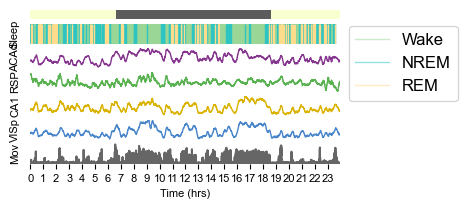

In [5]:
#Plotting step
fig,ax = plt.subplots(nrows=7,ncols=1,figsize=(4,2),
    gridspec_kw={'height_ratios': [1,2,2,2,2,2,2]},sharex=True)

#L/D Plotting
darktime = dtify(recstart.split('_')[0] + '_19-30-00') #hard coded
darktime_sec = (darktime - recstart_dt).seconds
darktime_bins = np.int(darktime_sec/binsz)

category_names = ['Light', 'Dark', 'Light']
category_colors = np.array([ld_clrs['light'],ld_clrs['dark'],ld_clrs['light']])
lefts = np.array([0,darktime_bins, darktime_bins + (12*3600*binsz)])
widths = np.array([darktime_bins,(12*3600*binsz),reclen-(darktime_bins+(12*3600*binsz))])

ax[0].invert_yaxis()
ax[0].xaxis.set_visible(False)

for c, (colname, color) in enumerate(zip(category_names, category_colors)):
    ax[0].barh([''], widths[c], left=lefts[c], height=0.5,
                    label=colname, color=color)
ax[0].axis('off')
#ax[0].text(darktime_bins,1,'test')
#End L/D Plotting

for r,roi in enumerate(regions):
    frsma = movmean(rsurates[r][:reclen],windowsize=600)
    ax[r+2].plot(frsma, color = reg_clrs[reg_names[roi]],label='Simple Moving Average', lw = 1)
    ax[r+2].set_ylabel(f'{roi}',fontsize=8)

ax[6].plot(loco[:reclen],alpha=0.6,color='black')
ax[6].set_ylabel('Mov',fontsize=8)

#sleep plotting
sleepdf_reclen = sleepdf[sleepdf.stop_time<(reclen/binsz)]

for c, statename in enumerate(np.unique(sleepdf_reclen.sleepstate)):
    
    state = sleepdf_reclen[sleepdf_reclen.sleepstate==statename]
    
    for j in range(len(state)):
        
        ax[1].axvspan(xmin=state["start_time"].iloc[j], xmax=state["stop_time"].iloc[j],
                      color=sleep_clrs[sleep_nums[statename]], alpha=1)

custom_lines = [Line2D([0], [0], color=sleep_clrs['active'], alpha=0.5, lw=1),
            Line2D([0], [0], color=sleep_clrs['NREM'], alpha=0.5, lw=1),
            Line2D([0], [0], color=sleep_clrs['REM'], alpha=0.5, lw=1)]

ax[1].legend(custom_lines,['Wake','NREM','REM'],bbox_to_anchor=(1,1.3),fontsize=12)

ax[1].set_ylabel('Sleep',fontsize=8)

for i in np.arange(1,7):
    ax[i].set_yticks([])

for i in np.arange(1,6):
    ax[i].xaxis.set_visible(False)
    
for i in np.arange(1,7):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

minbwtix = 60
xtix = np.arange(0,reclen,60*minbwtix/binsz)
xtixlabs = (xtix*binsz/3600).astype(int)

ax[6].set_xticks(xtix)
ax[6].set_xticklabels(xtixlabs,fontsize=8)
ax[6].set_xlabel('Time (hrs)',fontsize=8)

plt.xlim(0,reclen)

if dump:
    filename = '_longterm_recording_fig.pdf'
    plt.savefig(pth+today+filename, bbox_inches='tight')
else:
    pass

plt.show()

In [6]:
headdir = f'{basedir}/data/'

n_wt_all = np.load(headdir+'wt_mod.npy', allow_pickle=True)
n_app_all = np.load(headdir+'app_mod.npy', allow_pickle=True)

n_wt = nrnlist_by_quality(n_wt_all,[1])
n_app = nrnlist_by_quality(n_app_all,[1])

nrns = n_wt + n_app

In [7]:
colarray = np.tile(np.linspace(0,1,10),np.ceil(len(nrns)/10).astype('int'))[:len(nrns)]
col = plt.cm.viridis(colarray)

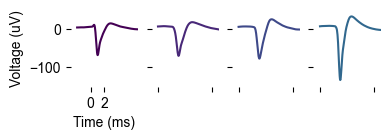

In [8]:
xtickpos = np.array([50,100])
xticklabs = (xtickpos/25000 * 1e3).astype(int) - 2

usethese = [18, 314, 316, 325]

nrns2 = [nrns[i] for i in usethese]

fign, axn = plt.subplots(ncols = 4, nrows = 1, figsize = [4,1])

for i,n in enumerate(nrns2):
    
    wfdat = n.waveforms
    axn[i].plot(wfdat,c=col[i])
    axn[i].set_ylim(-150,50)
    
    midpt = np.argmin(wfdat)
    axn[i].set_xlim(midpt-100,midpt+150)
    
    if i == 0:
        axn[i].set_xticks(xtickpos)
        axn[i].set_xticklabels(xticklabs)

        axn[i].set_ylabel('Voltage (uV)')
        axn[i].set_xlabel('Time (ms)')
    else:

        axn[i].set_xticklabels('')
        axn[i].set_yticklabels('')
        axn[i].set_ylabel('')
        axn[i].set_xlabel('')
        

sns.despine(left = True, bottom = True)

if dump:
    plt.savefig(pth+today+'_meanWFs_'+'.pdf')
else:
    pass

#     plt.show()

In [9]:
nrnlist = np.array(list(n_wt_all) + list(n_app_all))
goodcells = [92, 430, 504, 544, 632]

n_lines = len(goodcells)
col = np.arange(1, n_lines + 1)

norm = mpl.colors.Normalize(vmin=col.min(), vmax=col.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

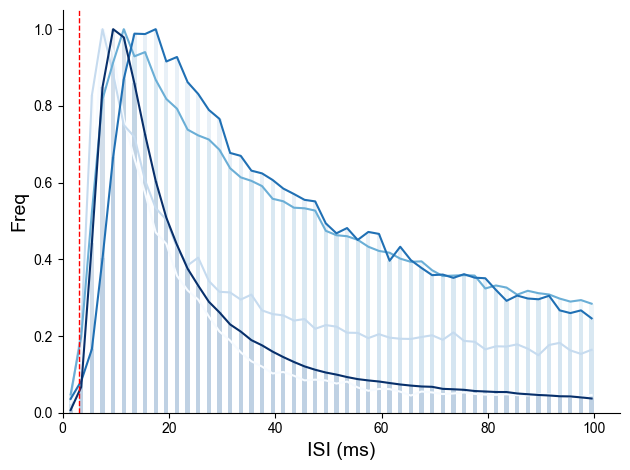

In [10]:
# '#5DADE2'

for i,c in enumerate(goodcells):
# i = 544
    cell = nrnlist[c]
    time_s = cell.spike_time/cell.fs
    start = cell.start_time
    end = cell.end_time
    idx = np.where(np.logical_and(time_s >= start, time_s <= end))[0]
    ISI = np.diff(time_s[idx])
    edges = np.linspace(0, 0.1, 51)
    hist_isi = np.histogram(ISI, edges)
    plt.bar(edges[1:]*1000-0.5, hist_isi[0]/np.max(hist_isi[0]), color= cmap.to_rgba(i + 1),alpha=0.1)
    plt.plot(edges[1:]*1000-0.5, hist_isi[0]/np.max(hist_isi[0]), color= cmap.to_rgba(i + 1))
#     plt.bar(edges[1:]*1000-0.5, hist_isi[0], color= cmap.to_rgba(i + 1),alpha=0.2)
#     plt.plot(edges[1:]*1000-0.5, hist_isi[0], color= cmap.to_rgba(i + 1))

plt.axvline(x=3, color='r', linestyle='dashed', linewidth=1) #dashed line at 3 ms
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('ISI (ms)',fontsize=14)
plt.ylabel('Freq',fontsize=14)

plt.tight_layout()
sns.despine()

if dump:
    filename = f'ISIs_representative.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [11]:
epochstatscsv = f'{basedir}/data/epoch_stats_100ms.csv'

epochstats = pd.read_csv(epochstatscsv)
epochstats['sleepoch'] = ['_'.join(i) for i in zip(epochstats['date'].astype(str), epochstats['recepoch'].astype(str), epochstats['epoch'].astype(str))]

epochagg = epochstats[['geno','state','sleepoch','animal','epoch_len']].groupby(['geno','state','sleepoch']).max().reset_index()
epochagg = epochagg.sort_values(['geno','state'], ascending = [False,True])

ind = np.unique(epochagg.animal, return_index=True)[1]
animallist = [epochagg.animal.iloc[i] for i in sorted(ind)]

time_in_state = np.zeros([8,3])
for a, animal in enumerate(animallist):
    for s,state in enumerate(['active','nrem','rem']):
        time_in_state[a,s] = np.sum(epochagg[(epochagg.animal==animal)&(epochagg.state==state)].epoch_len)
        
time_in_state_mean_wt = np.mean(time_in_state[:4,:],axis=0)
time_in_state_mean_app = np.mean(time_in_state[4:,:],axis=0)

perc_in_state = (time_in_state.T/np.sum(time_in_state,axis=1)).T
perc_in_state_mean_wt = np.mean(perc_in_state[:4,:],axis=0)
perc_in_state_mean_app = np.mean(perc_in_state[4:,:],axis=0)

epochstats['adr_id'] = epochstats['animal'] + '_' + epochstats['date'].astype(str) + '_' + epochstats['recepoch']

selected_recepochs = ['CAF69_1230_12_24', 'CAF71_103_0_12', 'CAF73_120_4_15', 'CAF74_125_48_60',
'CAF75_125_53_64', 'CAF77_202_12_24', 'CAF81_304_12_24', 'CAF82_304_12_24']

epochstats_1rec = epochstats[epochstats.adr_id.isin(selected_recepochs)]
epoch_meanfr = epochstats_1rec[['epoch','fr_mean','state','geno','region']]
epoch_meanfr['cell'] = epochstats_1rec['animal'] + '_' + epochstats_1rec['region'] + '_' + epochstats_1rec['nrnind'].astype('str')
epoch_meanfr['recdate'] = epochstats_1rec['date'].astype('str') + '_' + epochstats_1rec['recepoch']
epoch_meanfr_agg = epoch_meanfr.groupby(['cell','recdate','state','geno','region'],as_index=False).mean()
epoch_meanfr_agg = epoch_meanfr_agg.drop('epoch',axis=1)
epoch_meanfr_agg['n_epoch'] = epoch_meanfr.groupby(['cell','recdate','state','geno','region'],as_index=False).count()['epoch']


/tmp/ipykernel_6898/2813084234.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epoch_meanfr['cell'] = epochstats_1rec['animal'] + '_' + epochstats_1rec['region'] + '_' + epochstats_1rec['nrnind'].astype('str')
/tmp/ipykernel_6898/2813084234.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epoch_meanfr['recdate'] = epochstats_1rec['date'].astype('str') + '_' + epochstats_1rec['recepoch']


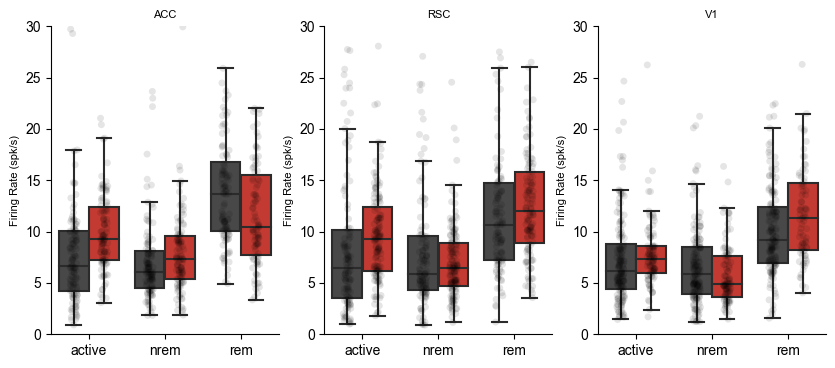

In [12]:
figf, axf = plt.subplots(ncols = 3, nrows = 1, figsize = [10,4])

regions = np.unique(epoch_meanfr_agg.region)

for i, roi in enumerate(regions):
    sns.boxplot( x='state', y='fr_mean', hue='geno', data = epoch_meanfr_agg[epoch_meanfr_agg.region==roi],
                   palette = [geno_clrs['WT'],geno_clrs['APP']], fliersize=0, ax = axf[i])
    
    sns.stripplot( x='state', y='fr_mean', hue='geno', data=epoch_meanfr_agg[epoch_meanfr_agg.region==roi],
               palette = ['black', 'black'], dodge=True, alpha = 0.1, ax = axf[i], edgecolor = ['white','white'])
    
    axf[i].set_title(str(roi).upper(),fontsize=8)
    axf[i].set_ylabel('Firing Rate (spk/s)',fontsize=8)
    axf[i].set_xlabel('')

    axf[i].set_ylim(0,30)
    sns.despine()
    axf[i].legend([],[], frameon=False)
    
if dump:
    filename = f'_meanfr_by_state_boxplot.pdf'
    plt.savefig(pth+today+filename)
else:
    pass
plt.show()